In [115]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from uncertainties import ufloat
import os
#from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
import numpy
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [17]:
#Coding up the Model Definition

# Susceptible equation
def dS_dt(S, I, R_t, T_inf):
    return -(R_t / T_inf) * I * S

# Exposed equation
def dE_dt(S, E, I, R_t, T_inf, T_inc):
    return (R_t / T_inf) * I * S - (T_inc**-1) * E

# Infected equation
def dI_dt(I, E, T_inc, T_inf):
    return (T_inc**-1) * E - (T_inf**-1) * I

# Recovered/Remove/deceased equation
def dR_dt(I, T_inf):
    return (T_inf**-1) * I


def SEIR_model(t, y, R_t, T_inc,R_0,L,k,T_inf):
    
    if callable(R_t):
        reproduction = R_t(t,R_0,L,k)
    else:
        reproduction = R_t
        
    S, E, I, R = y
    
    S_out = dS_dt(S, I, reproduction, T_inf)
    E_out = dE_dt(S, E, I, reproduction, T_inf, T_inc)
    I_out = dI_dt(I, E, T_inc, T_inf)
    R_out = dR_dt(I, T_inf)
    
    return [S_out, E_out, I_out, R_out]

In [131]:
#Loading the  i/p data
#df_All_Cases  = pd.read_csv(r"C:\Covid19_SEIR\covid_19_clean_complete.csv")
#df_Population  = pd.read_csv(r"C:\Covid19_SEIR\Country_Population.csv") 
df_Date_Volataility  = pd.read_csv(r"C:\Covid19_SEIR\Country_Date_Volataility.csv") 
#Tests_raw=pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/testing/covid-testing-all-observations.csv')
df_All_Cases_Raw=pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')

In [148]:
#Tests_All_Countries=Tests_raw[~Tests_raw.Entity.isin(['Italy - people tested','India - people tested'])][['Entity','Date', 'Cumulative total']]
#Tests_All_Countries['Entity']=Tests_All_Countries['Entity'].str.split('-').str[0].str.strip()
#Tests_All_Countries.rename(columns={'Entity': 'Country'}, inplace=True)
#Tests_All_Countries=Tests_All_Countries[["Country","Date","Cumulative total"]].groupby(["Country","Date"]).sum().reset_index()

In [ ]:
df_All_Cases=df_All_Cases_Raw[["location","date","total_cases","population","total_tests","total_tests_per_thousand"]].groupby(["location","date"]).max().reset_index()
df_All_Cases["date"]=pd.to_datetime(df_All_Cases["date"])
df_All_Cases["Test_Per_M"]=df_All_Cases["total_tests_per_thousand"]*1000
df_All_Cases.columns =["Country","Date","Confirmed","Population","Total_Tests","Tests_Per_Thousand","Test_Per_M"]

In [ ]:
#Test_Norm=Tests_All_Countries[Tests_All_Countries["Country"].isin(['Italy'])][["Country","Date","Cumulative total"]].groupby(["Country","Date"]).sum().reset_index()
#Test_Norm['Norm_Daily_Tests'] =Test_Norm['Cumulative total'].diff().fillna(0)
#Test_Norm['Norm_Rolling_7_Day_Tests'] =Test_Norm['Cumulative total'].diff().fillna(0).rolling(7).mean().fillna(0)
#Test_Norm["Date"]=pd.to_datetime(Test_Norm["Date"])


#df_Italy = df_All_Cases[df_All_Cases["Country/Region"]=='Italy'][["Country/Region","Date","Confirmed","Deaths","Recovered"]].groupby(["Country/Region","Date"]).sum().reset_index()
#df_Italy["Date"]=pd.to_datetime(df_Italy["Date"])
#df_Italy = df_Italy.sort_values("Date")
#df_Italy = df_Italy[df_Italy.Confirmed>0].reset_index(drop=True)
#df_Italy = df_Italy.merge(df_Population,left_on= "Country/Region",right_on ="Country")
#Test_Norm_Final = df_Italy.merge(Test_Norm ,how='left',left_on="Date", right_on="Date")
#Test_Norm_Final=Test_Norm_Final[["Country/Region","Date","Cumulative total","Population"]]
#Test_Norm_Final['Test_per_M_Norm']=Test_Norm_Final['Cumulative total']/Test_Norm_Final['Population']*1000000
#Test_Norm_Final['Test_per_M_Norm']=Test_Norm_Final['Test_per_M_Norm'].fillna(np.nanmin(Test_Norm_Final['Test_per_M_Norm']))
#Test_Norm_Final=Test_Norm_Final[['Date', 'Test_per_M_Norm']]
#Test_Norm_Final

In [119]:
Test_Norm=df_All_Cases_Raw[df_All_Cases_Raw.iso_code=='ITA'][["date","total_cases","population","total_tests","total_tests_per_thousand"]].groupby(["date"]).max().reset_index()
Test_Norm["date"]=pd.to_datetime(Test_Norm["date"])
Test_Norm=Test_Norm.sort_values("date")
Test_Norm =Test_Norm[Test_Norm.total_cases>0].reset_index(drop=True)

Test_Norm["Test_per_M_Norm"]=Test_Norm["total_tests_per_thousand"]*1000
Test_Norm_Final=Test_Norm[["date","total_cases","total_tests","population","Test_per_M_Norm"]]
Test_Norm_Final.columns=["Date","Total_Cases","Total_Tests","Population","Test_per_M_Norm"]

min_test_pm=np.nanmin(Test_Norm_Final['Test_per_M_Norm'])
Test_Norm_Final['Test_per_M_Norm'].fillna(min_test_pm,inplace =True)

Test_Norm_Final['Test_per_M_Norm']=Test_Norm_Final['Test_per_M_Norm'].cummax()
Test_Norm_Final["Positive_Test_Rate_Norm"]=Test_Norm_Final["Total_Cases"]/(Test_Norm_Final["Test_per_M_Norm"]*(Test_Norm_Final["Population"]/1000000))*100



## Testing Adjuste Covid-19 Infection Curves for Countries and Projected End Dates

T_50 :   Date by which daily cases fall to 50% of the projected peak daily cases 

T_25 :   Date by which daily cases fall to 25% of the projected peak daily cases

T_10 :   Date by which daily cases fall to 10% of the projected peak daily cases

T_97.5 : Date by which total cases reach 97.5% of the projected total cases

In [15]:
# Time varying transmission rate

import math 
def time_varying_R(t,R_01,L_1,k_1): 
    return R_01 / (1 + (t/L_1)**k_1)


def time_varying_T(t,t_inf_0,t_inf_1):
    exponent = -t/(t_inf_1)
    if t<70:
        return t_inf_0 
    else:
        return t_inf_0*math.exp(exponent)

def time_varying_T2(t,t_inf_0,t_inf_1):
    exponent = -t/(t_inf_1)
    return t_inf_0*math.exp(exponent)  

In [13]:
def val_less_list(ip_df,val):
    if len(ip_df[ip_df.iloc[:,4]<=val].iloc[:,5].index) == 0:
        return min(ip_df.iloc[:,5])
    else:
        return np.max(ip_df[ip_df.iloc[:,4]<=val].iloc[:,5])

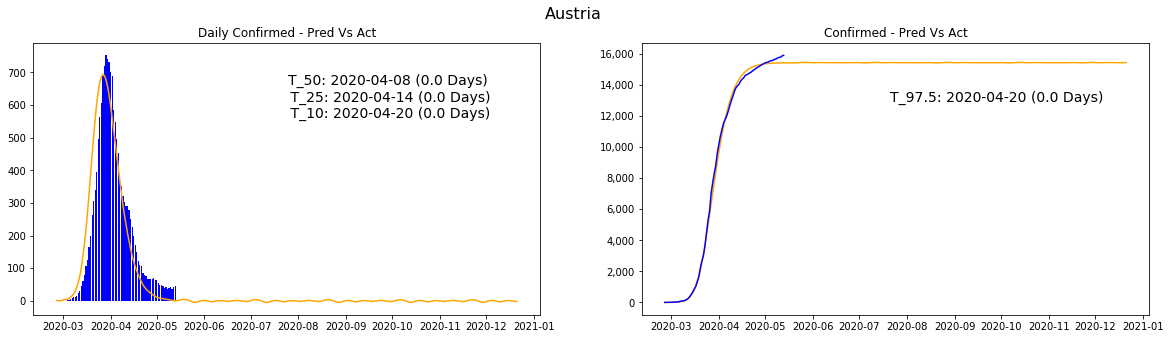

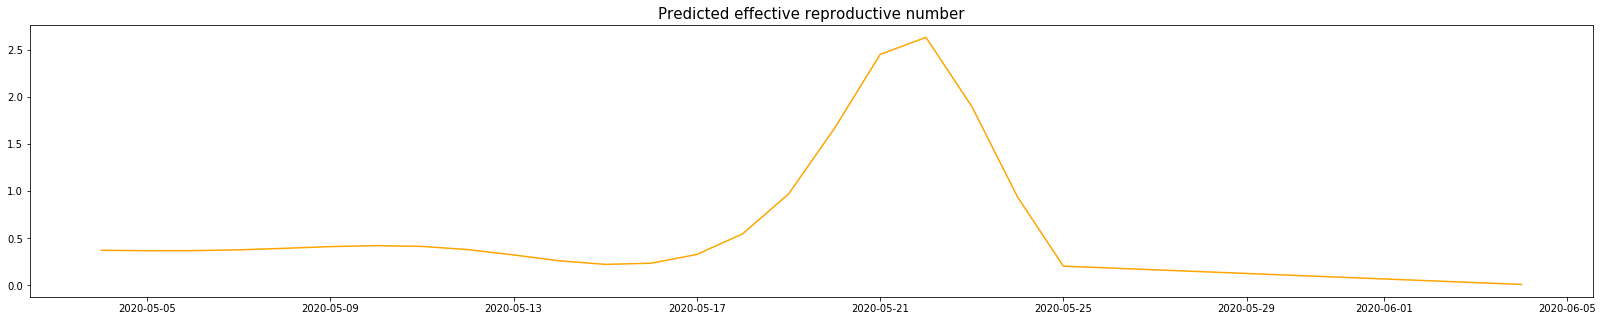

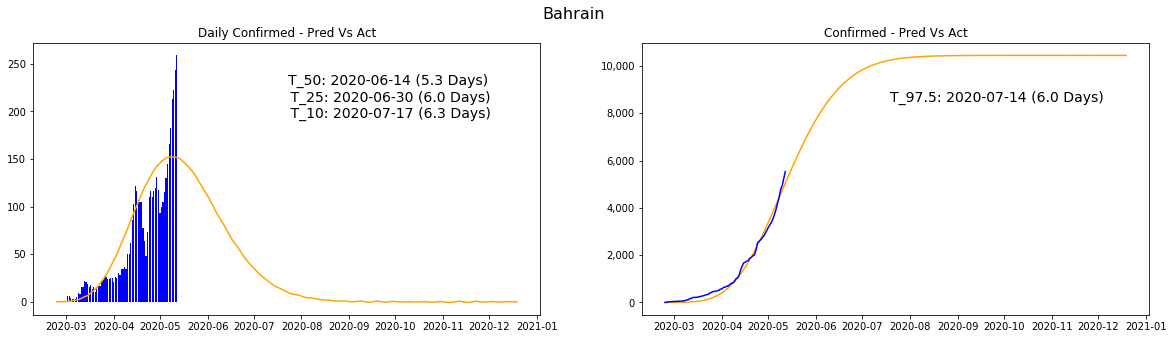

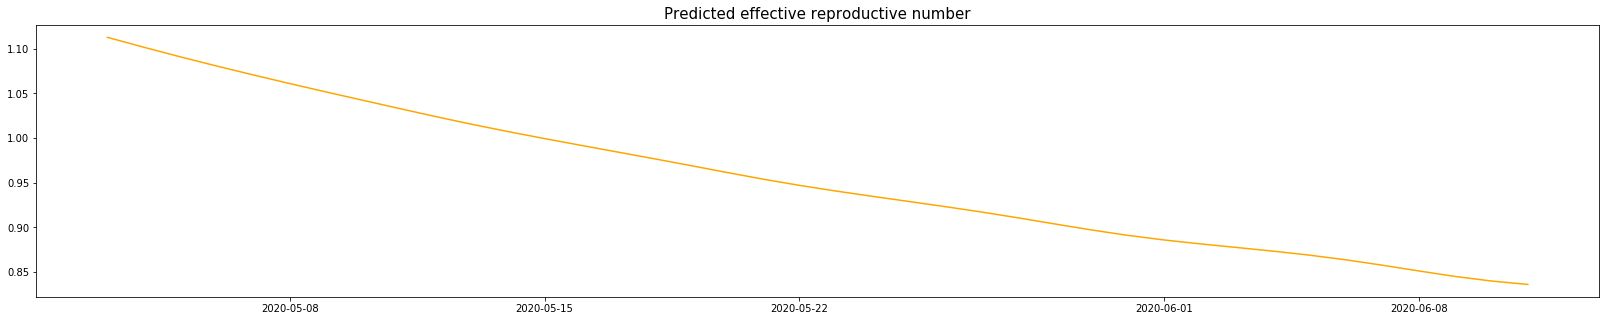

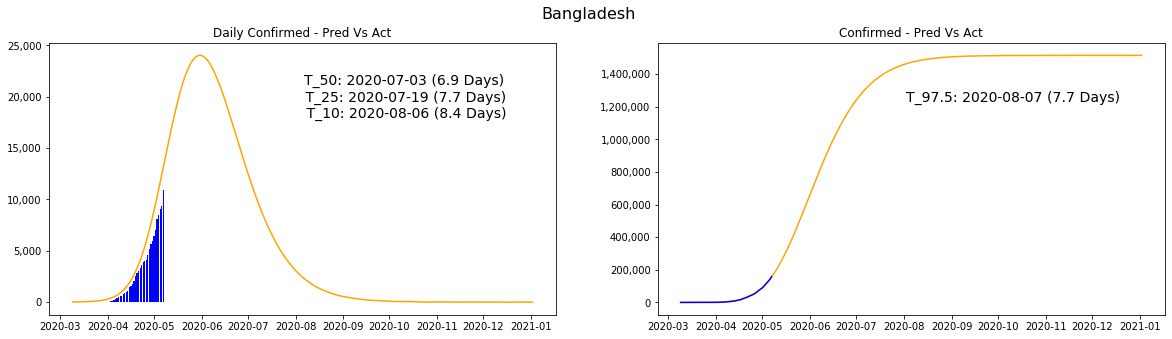

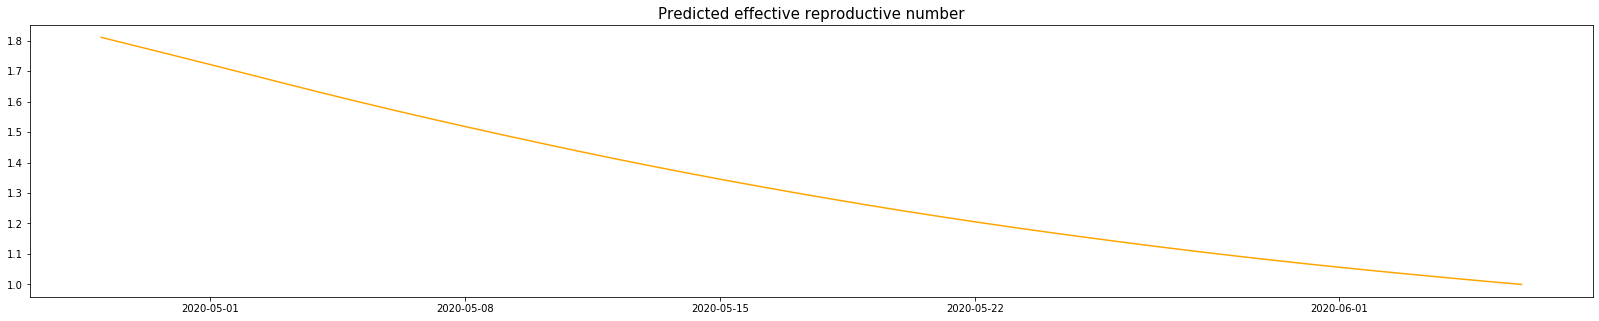

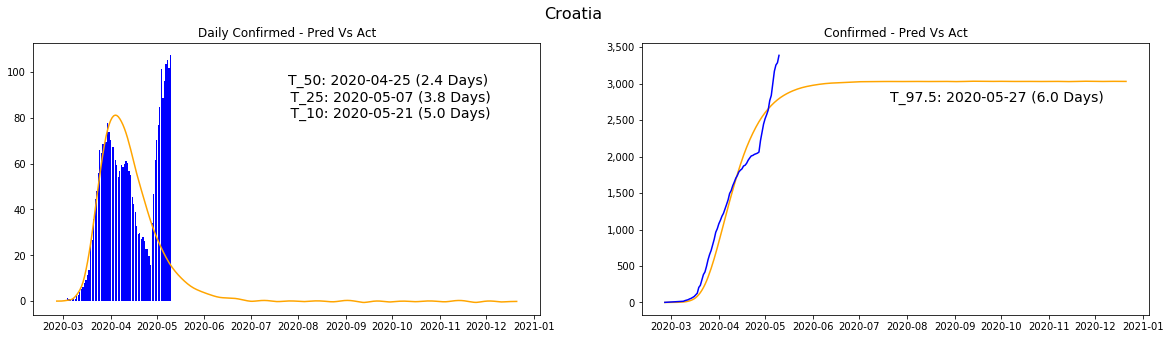

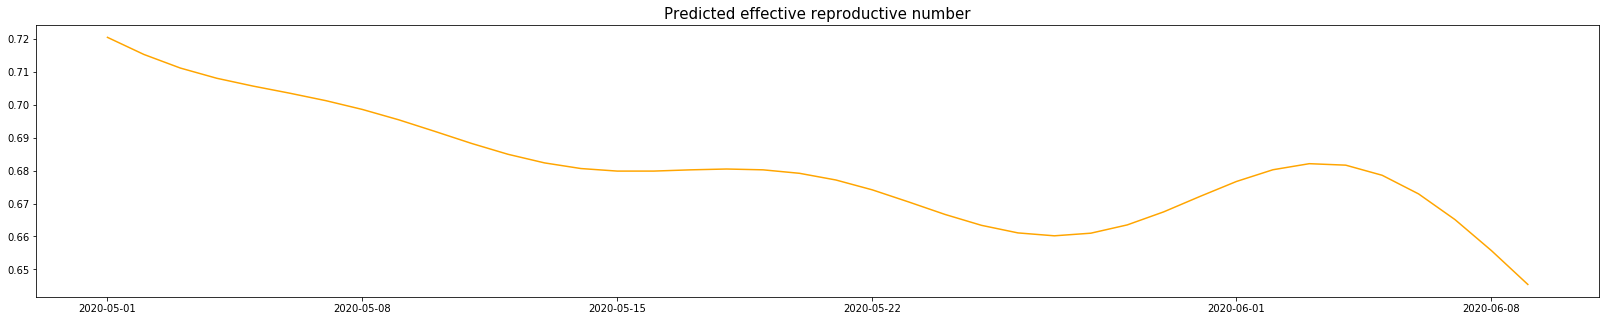

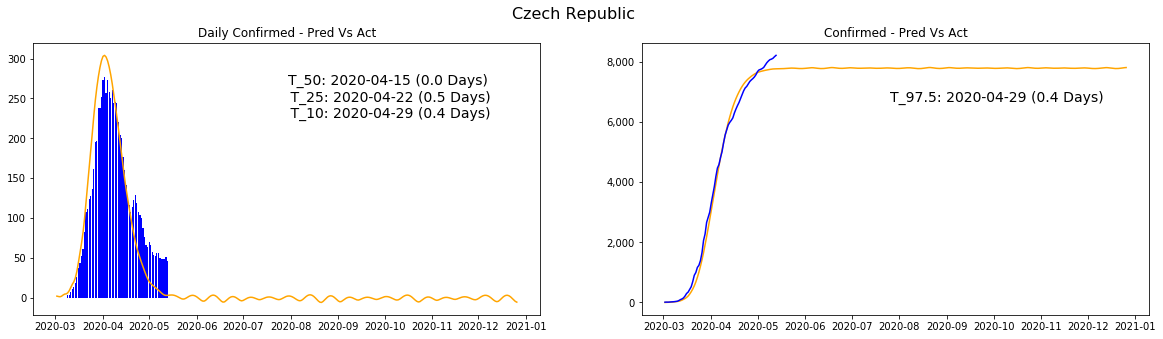

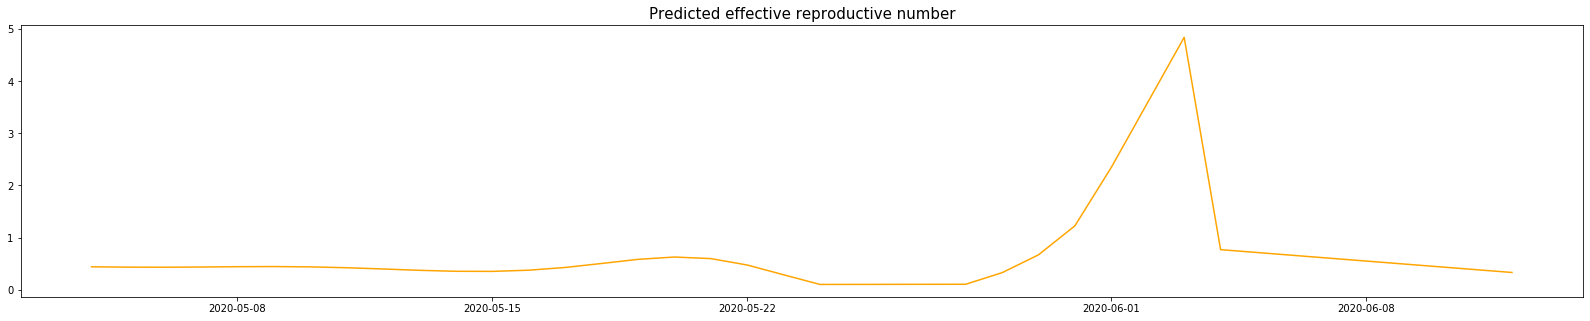

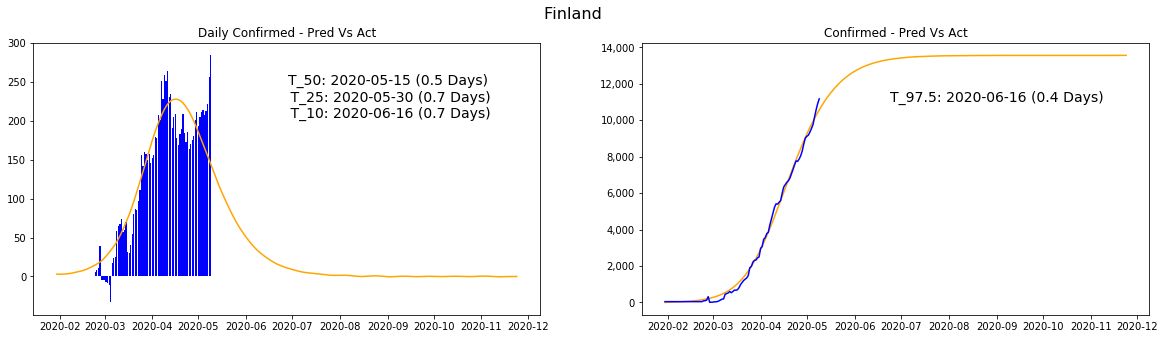

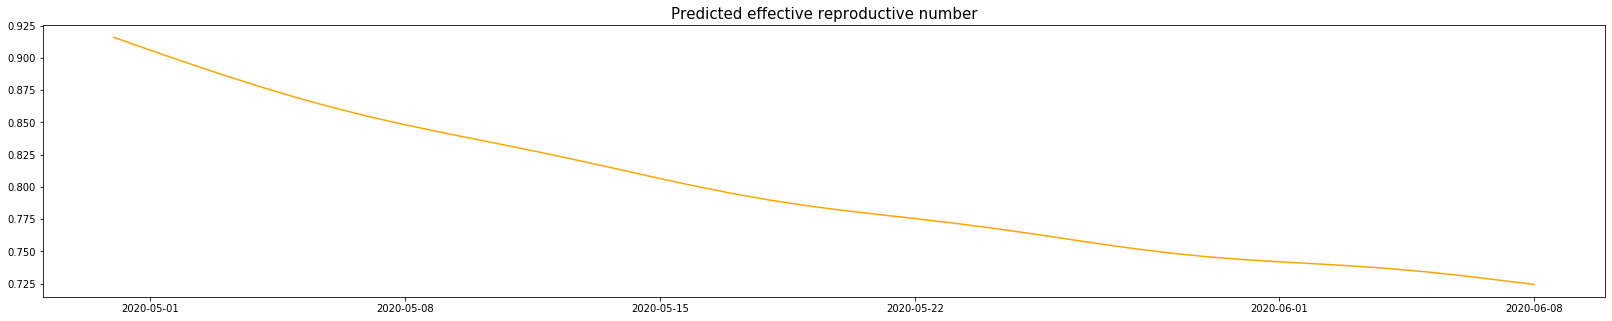

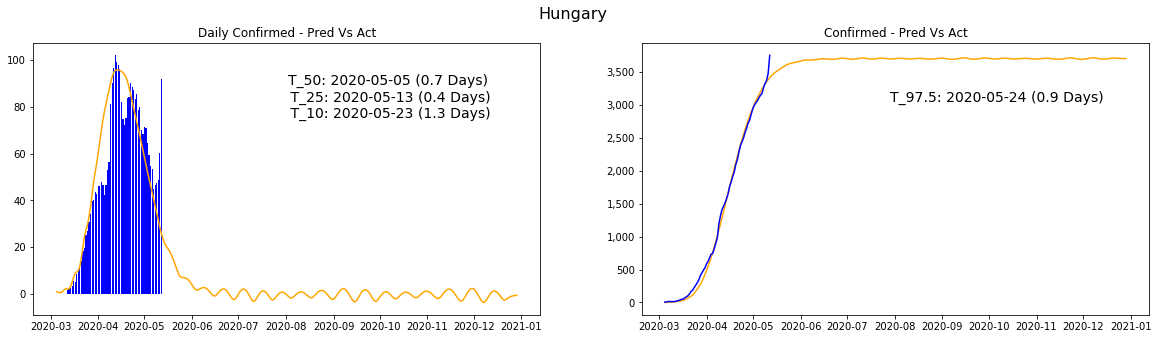

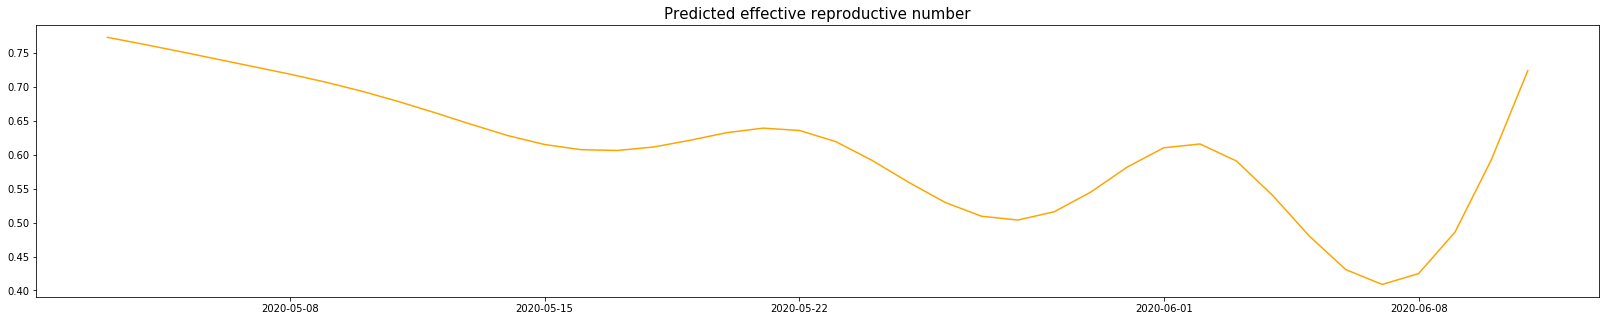

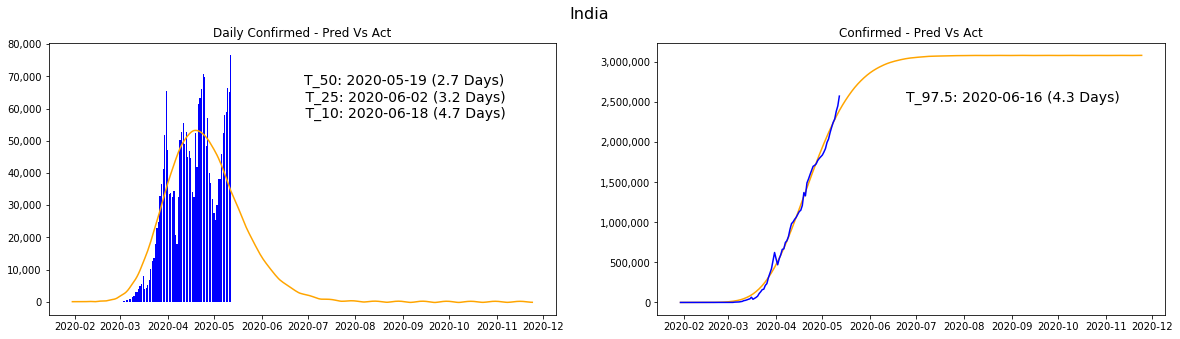

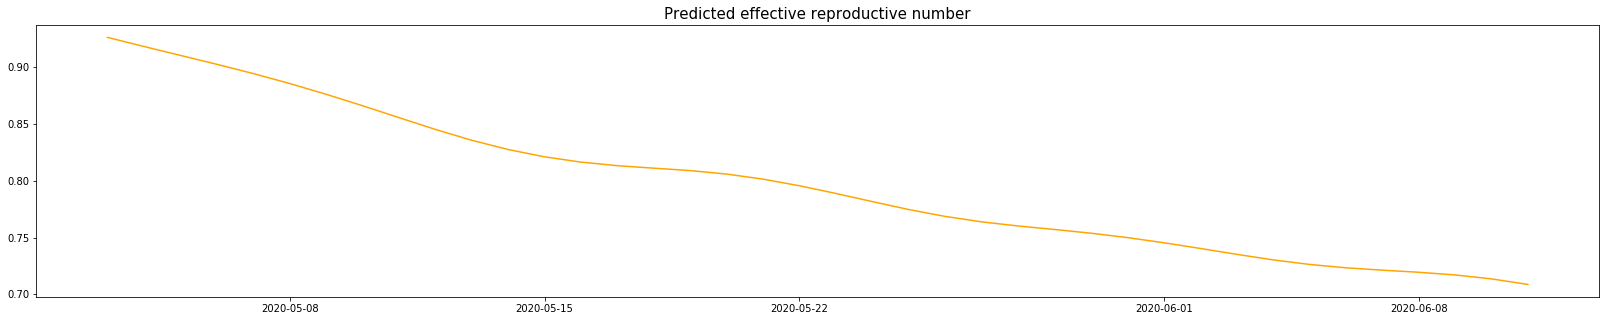

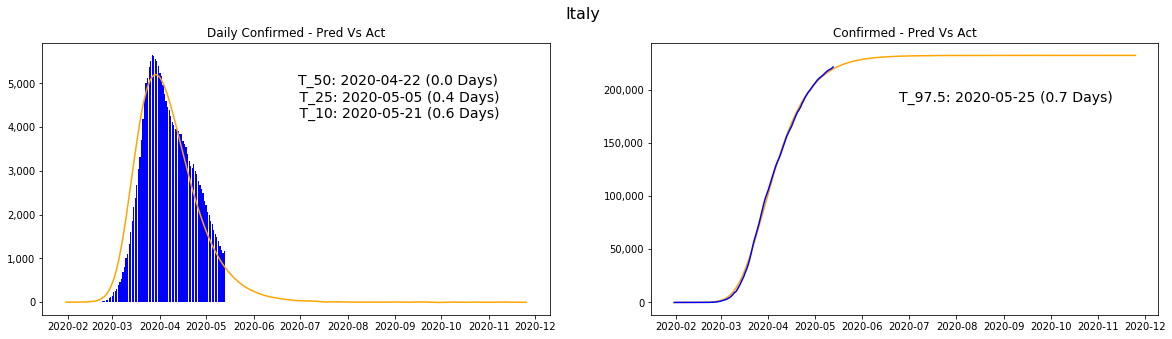

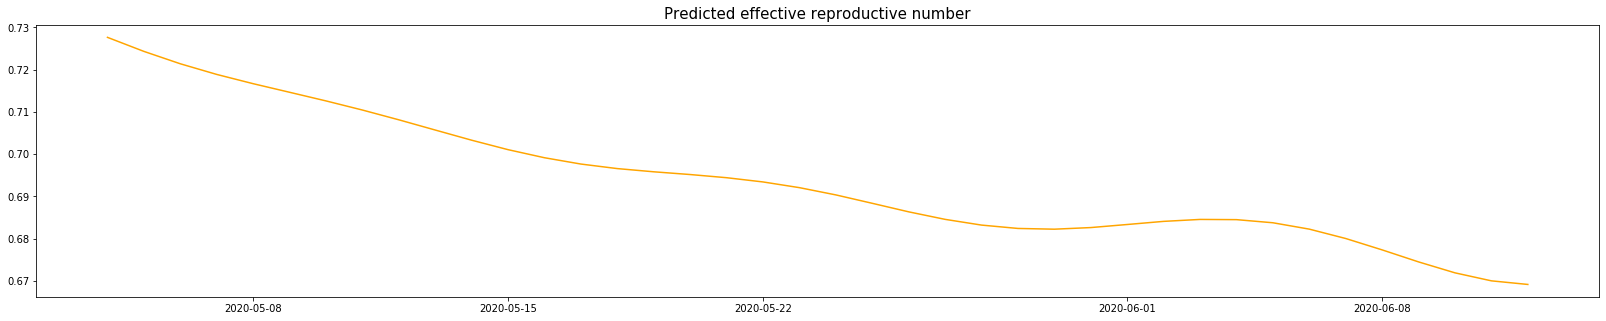

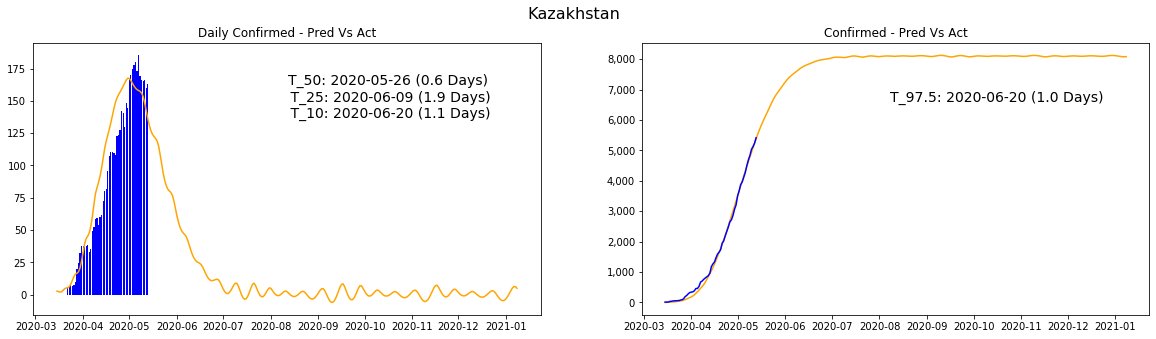

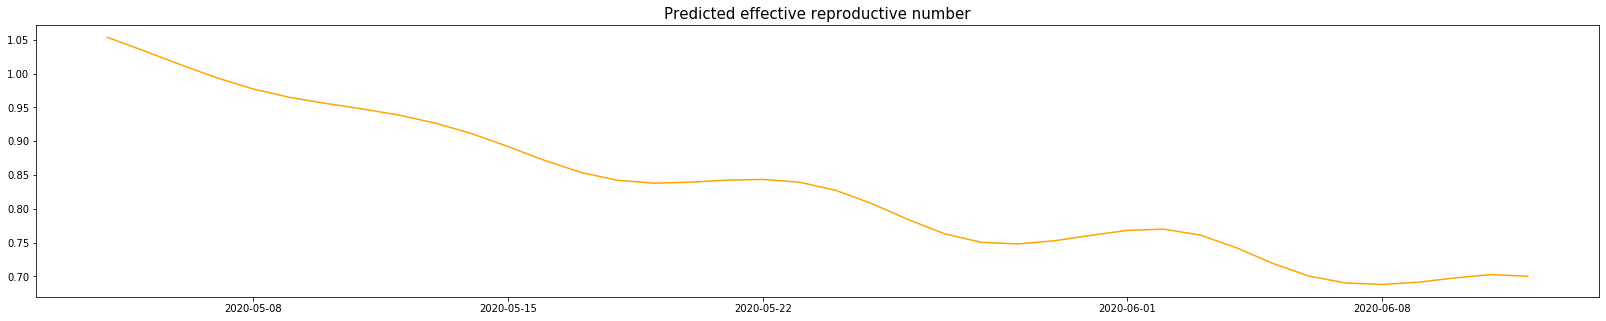

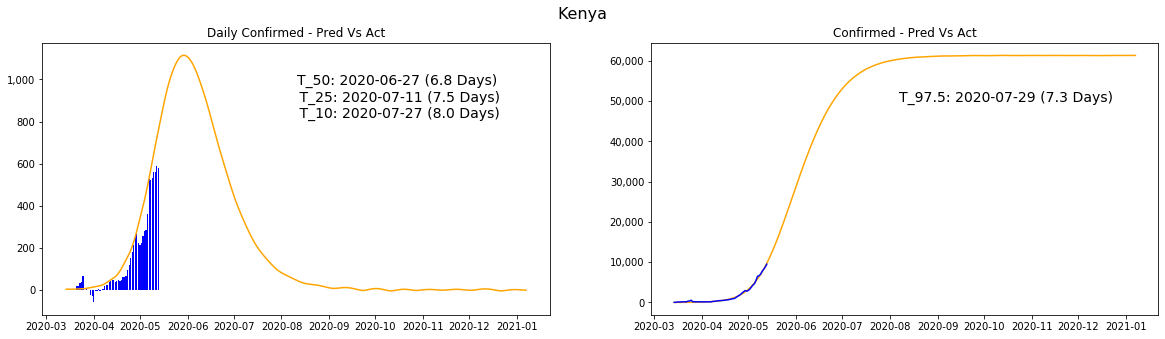

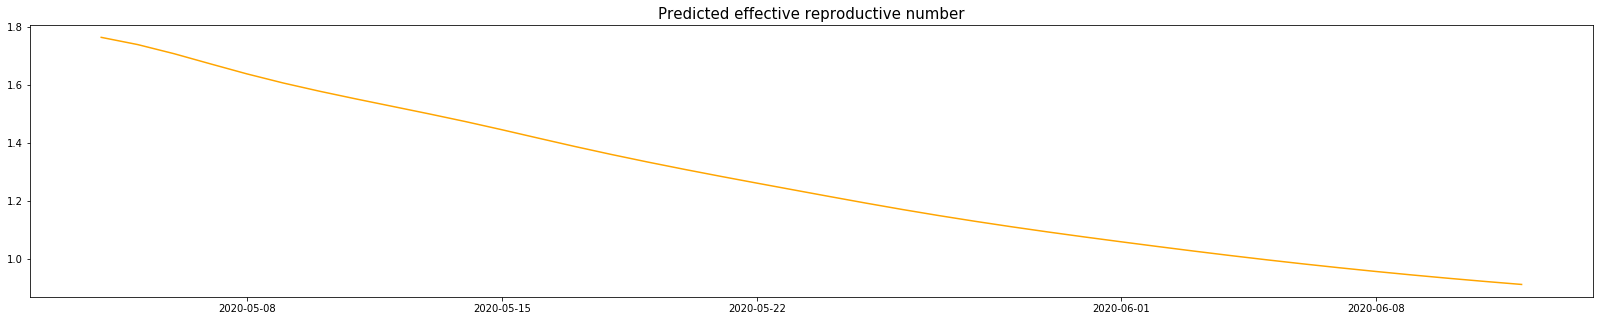

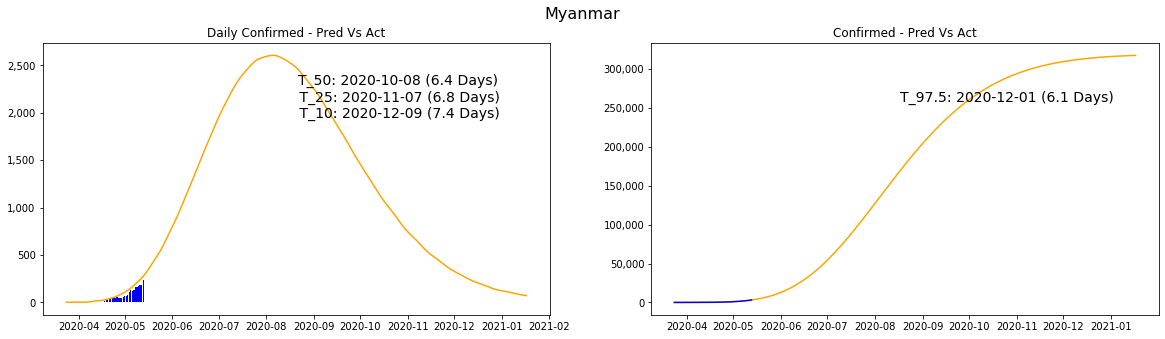

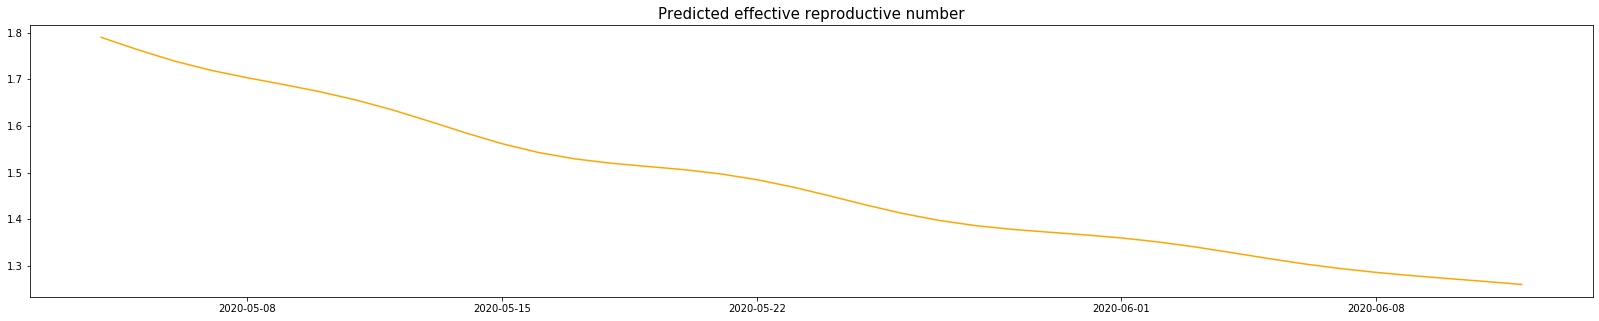

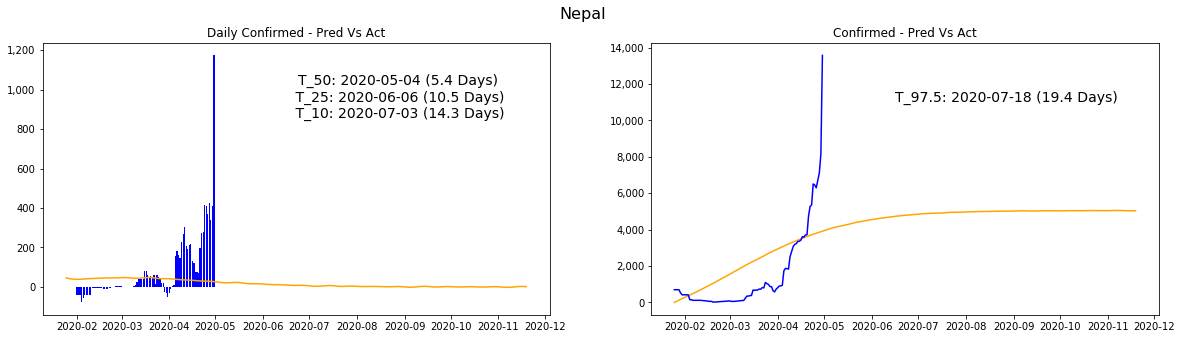

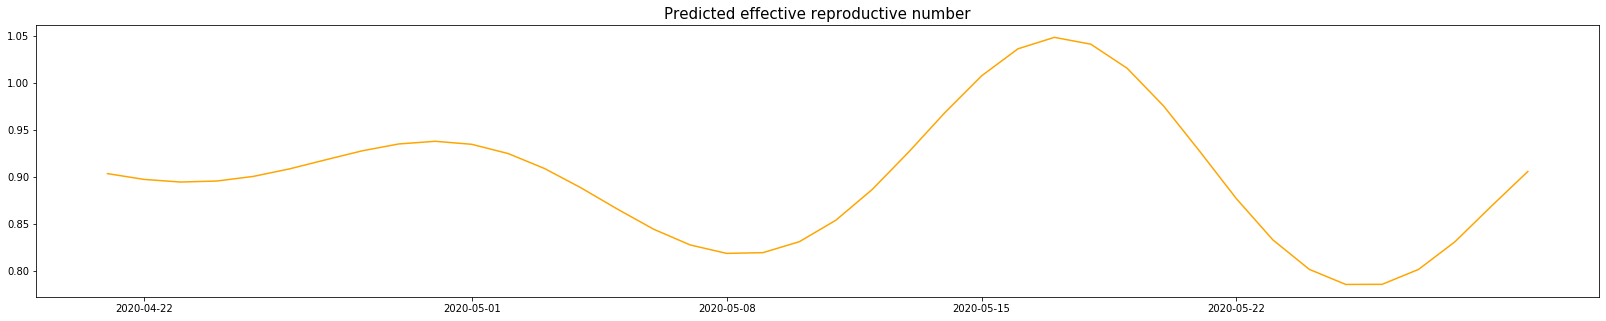

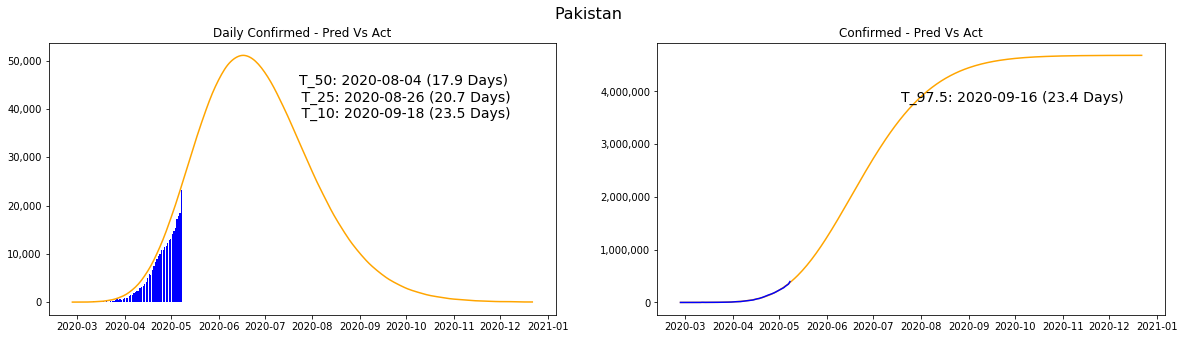

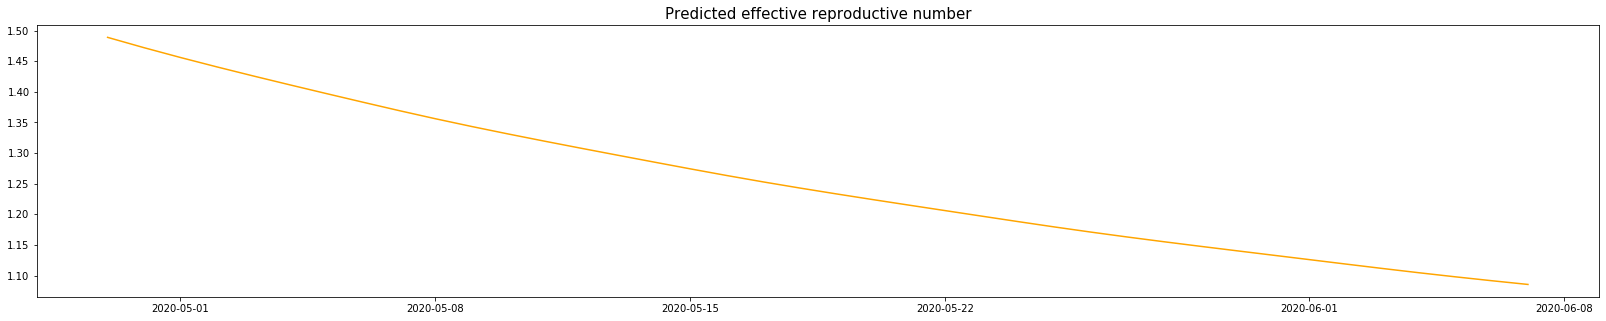

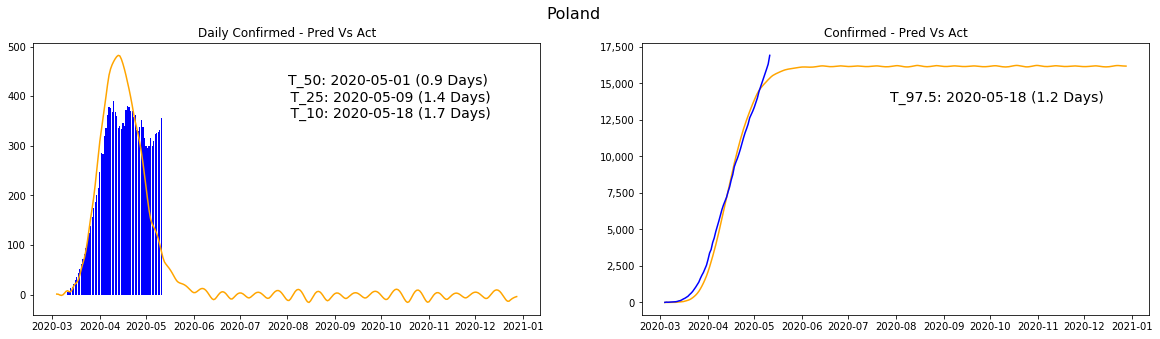

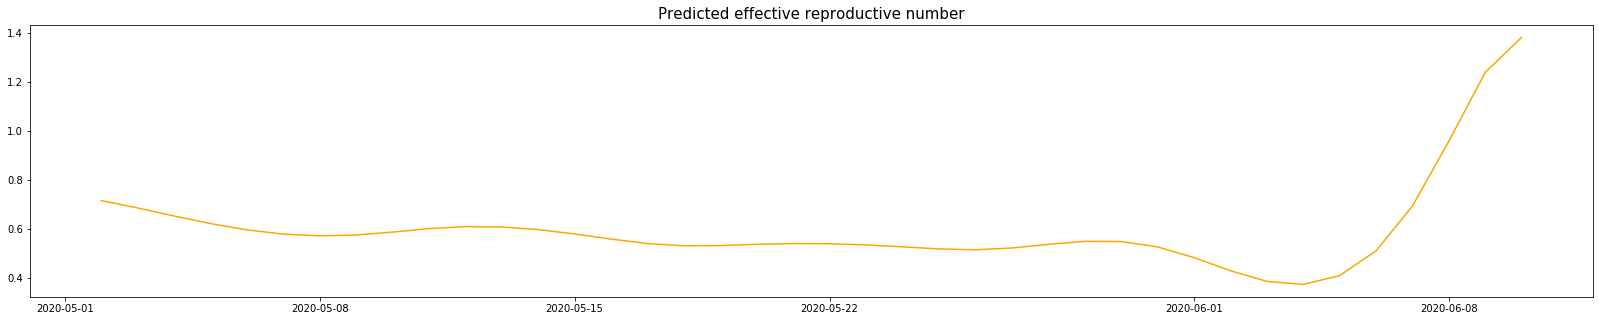

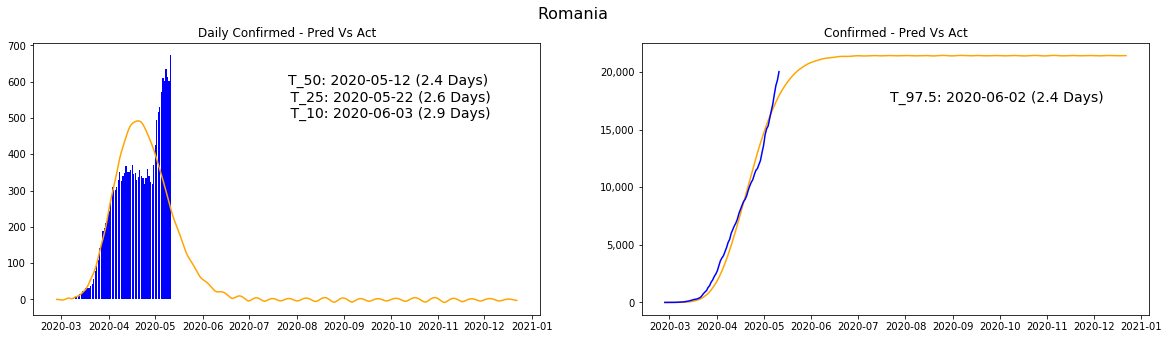

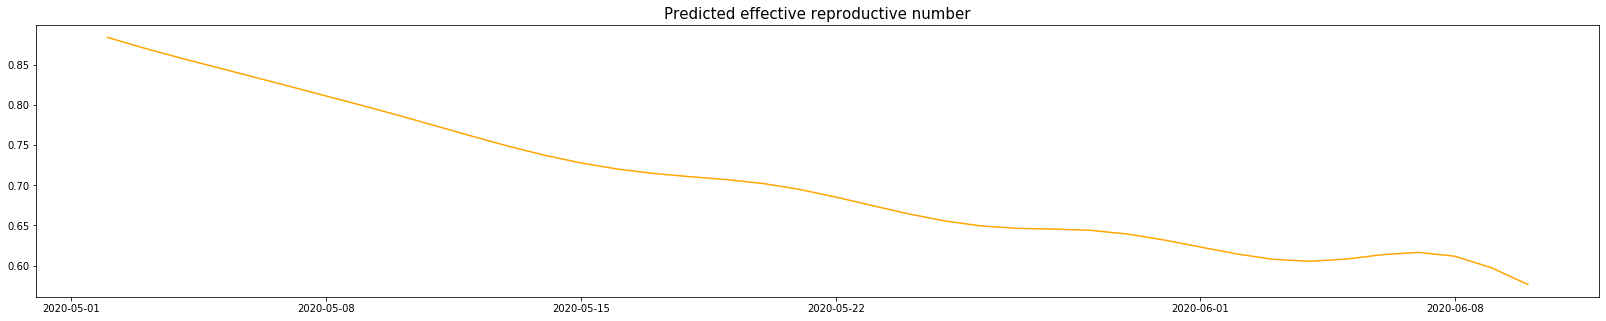

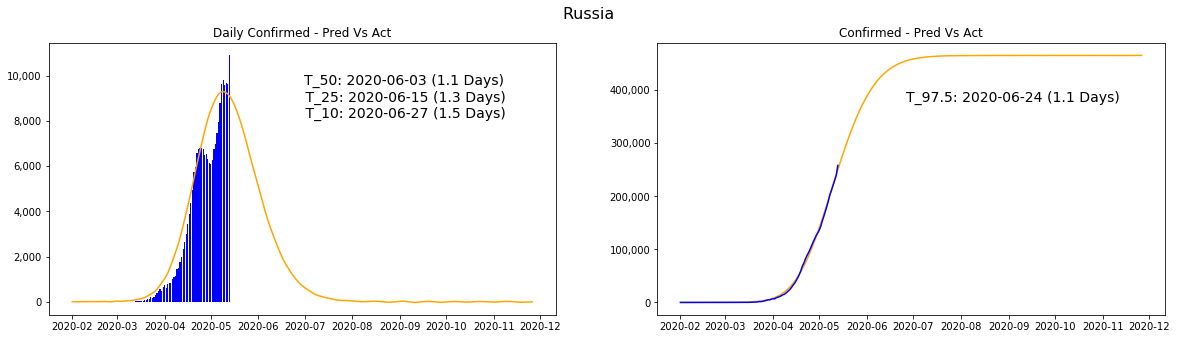

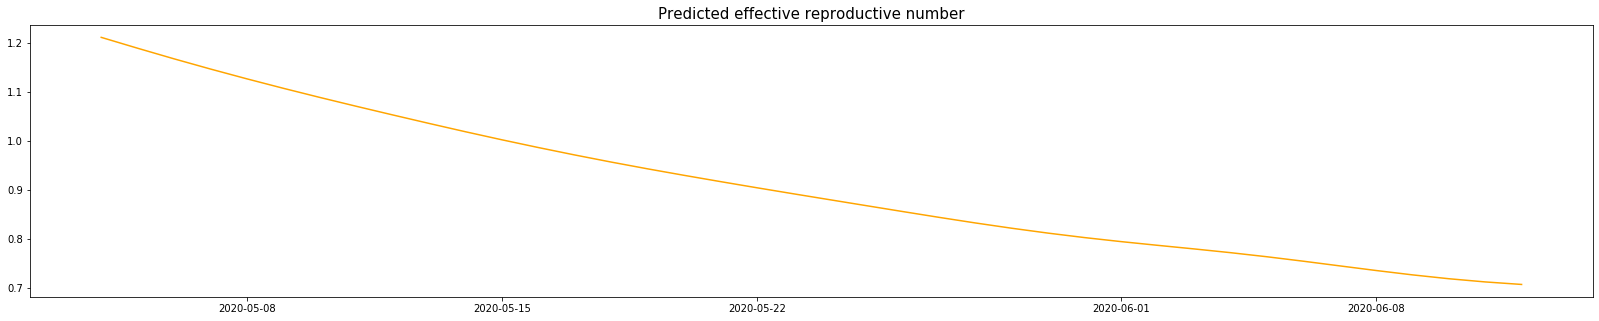

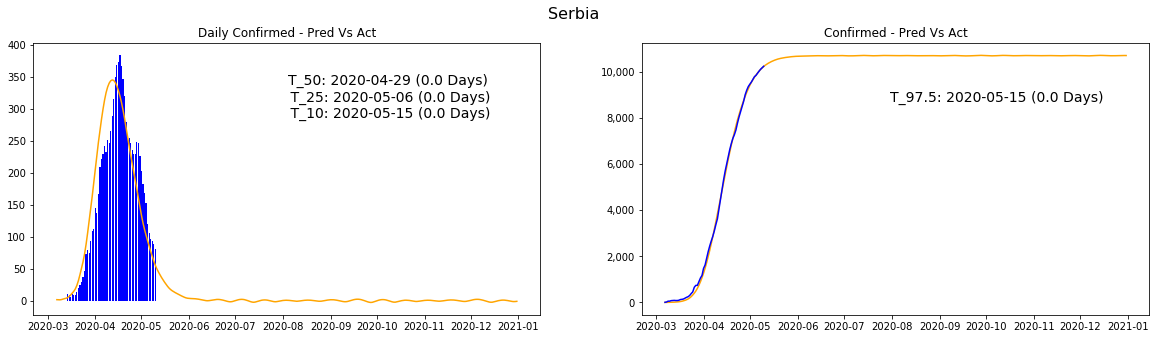

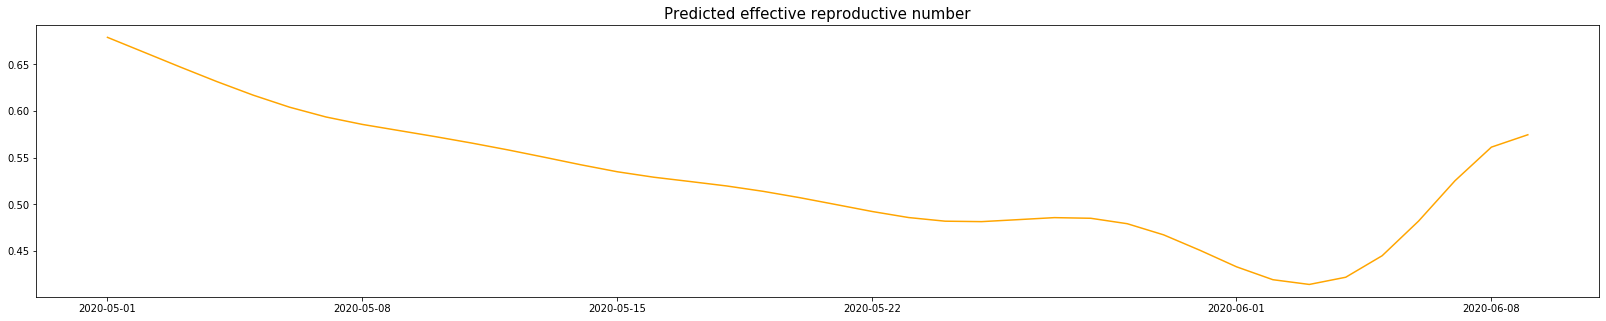

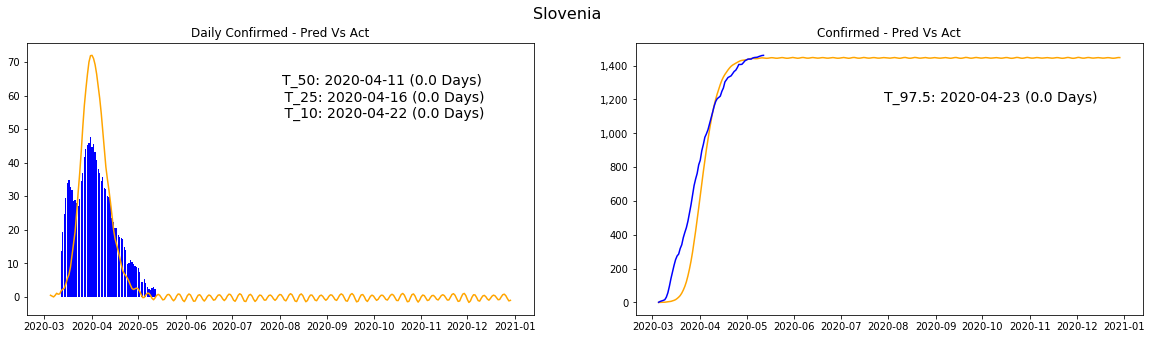

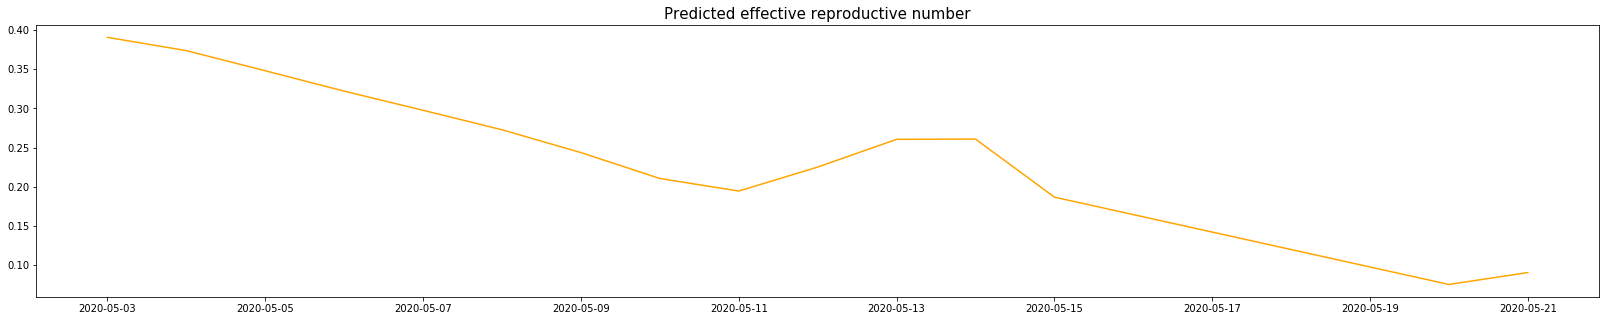

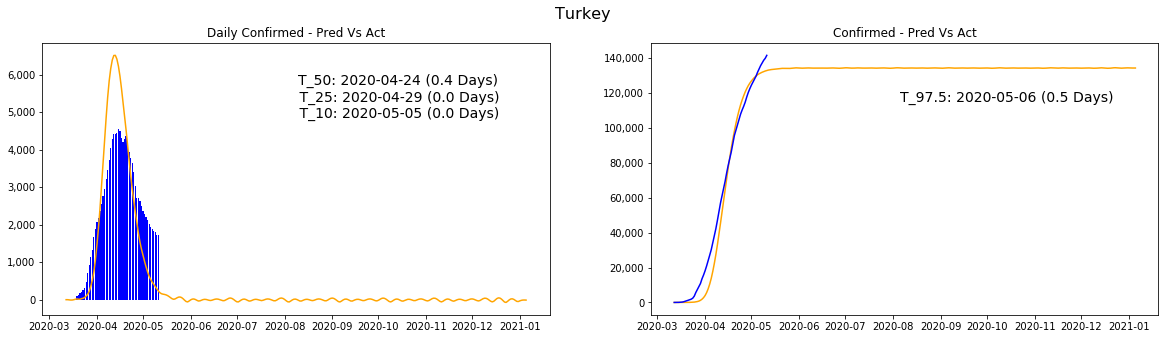

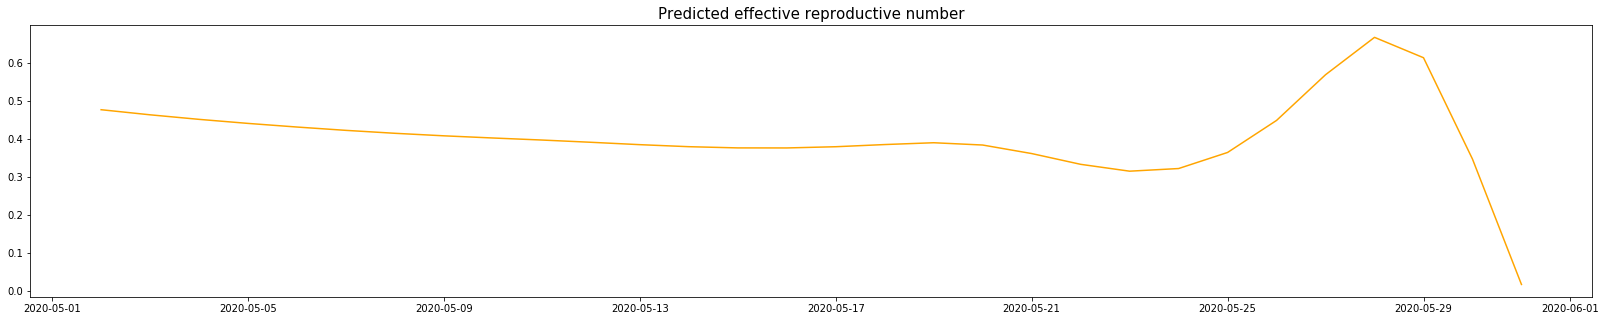

In [132]:
#country_list = ['Italy','Russia','Turkey','Iran','Saudi Arabia','Pakistan','United Arab Emirates',
#'Poland','Serbia','Bangladesh','Egypt','Finland','Kuwait','Kazakhstan',
#'Bahrain','Hungary','Thailand','Oman','Armenia','Iraq','Uzbekistan','Croatia','Romania','Sri Lanka','Jordan',
#'Azerbaijan','Bosnia and Herzegovina','Bulgaria','Afghanistan','India','North Macedonia','Slovenia','Slovakia','Djibouti',
#'Kyrgyzstan','Lebanon','Sudan','Tanzania','Kenya','Montenegro','Ukraine',
#'Uganda','South Sudan','Syria','Yemen','Czech','Nepal']

country_list =['Austria','Bahrain','Bangladesh','Croatia','Czech Republic','Finland','Hungary','India',
'Italy','Kazakhstan','Kenya','Myanmar','Nepal','Pakistan','Poland',
'Romania','Russia','Serbia','Slovenia','Turkey']


column_names =["Country","Snap_Date","T_50","T_25","T_10","T_97.5"]
Df_End_Dates = pd.DataFrame(columns =column_names )
Df_End_Dates

for country in country_list:
    #df_Cases=df_All_Cases[df_All_Cases["Country/Region"]=='Portugal'][["Country/Region","Date","Confirmed","Deaths","Recovered"]].groupby(["Country/Region","Date"]).sum().reset_index()
    df_Cases=df_All_Cases[df_All_Cases["Country"]==country][["Country","Date","Confirmed","Population","Total_Tests","Test_Per_M"]]
    df_Cases=df_Cases.sort_values("Date")
    df_Cases=df_Cases[df_Cases.Confirmed>0].reset_index(drop=True) #check
    #df_final = df_Cases.merge(df_Population,left_on= "Country/Region",right_on ="Country")
    
    #Tests_Country = Tests_All_Countries[Tests_All_Countries["Country"]=='Portugal']
    #Tests_Country["Date"]=pd.to_datetime(Tests_Country["Date"])
    #Tests_Country.rename(columns={'Cumulative total': 'Total_Tests'}, inplace=True)
    #Tests_Country['Daily_Tests'] =Tests_Country['Cumulative total'].diff().fillna(0)
    #Tests_Country['Rolling_7_Day_Tests'] =Tests_Country['Cumulative total'].diff().fillna(0).rolling(7).mean().fillna(0)
    
    #df_final = df_final.merge(Tests_Country,how='left',left_on= "Date",right_on ="Date")
    #df_final['Total_Tests'].fillna(np.nanmin(df_final['Total_Tests']),inplace=True)
    df_final=df_Cases
    df_final['Total_Tests'].fillna(np.nanmin(df_final['Total_Tests']),inplace=True)
    df_final['Total_Tests']=df_final['Total_Tests'].cummax()
    df_final['Test_Per_M']=df_final['Total_Tests']/df_final['Population']*1000000
    df_final["Positive_Rate"]=df_final["Confirmed"]/df_final["Total_Tests"]*100
    #df_final["Equ_Positive_Rate_Norm_low"]= df_final.apply(lambda x:val_less_list(Test_Norm_Final,x['Test_Per_M']), axis=1)
   
    #df_final = df_final.merge(Test_Norm,left_on= "Date",right_on ="Date")
    df_final=df_final.join(Test_Norm_Final[['Test_per_M_Norm','Positive_Test_Rate_Norm']],how='left', lsuffix='l', rsuffix='r',)
    #df_final["Positive_Rate_Ratio"]=df_final["Positive_Test_Rate_Norm"]/df_final["Equ_Positive_Rate_Norm_low"]
    
    #df_final["Positive_Rate_Ratio"]=df_final["Positive_Rate_Ratio"].clip(None,1.5)
    
    #df_final.loc[df_final['Test_Per_M'] >= df_final['Test_per_M_Norm'], 'Adj_Positive_Rate'] = df_final['Positive_Rate']/100
    #df_final.loc[df_final['Test_Per_M'] < df_final['Test_per_M_Norm'], 'Adj_Positive_Rate'] = df_final['Positive_Rate']* df_final["Positive_Rate_Ratio"]/100

    df_final["Test_Adj_Confrmd"]=(df_final["Positive_Rate"]/100)*(df_final['Test_per_M_Norm']*df_final['Population']/1000000)
    
    #df_final["Test_Adj_Confrmd"]=(df_final["Adj_Positive_Rate"])*(df_final['Test_per_M_Norm']*df_final['Population']/1000000)
    
    df_final["Test_Adj_Confrmd"] = df_final[["Test_Adj_Confrmd","Confirmed"]].max(axis=1)
    df_final["Test_Adj_Confrmd"].fillna(np.nanmax(df_final["Test_Adj_Confrmd"]),inplace=True)
    #df_final
    #df_final = df_final.merge(Test_Norm,left_on= "Date",right_on ="Date")


#deriving the input data column for training

    xdata = np.arange(len(df_final.Date))
    #xdata
#ydata = np.array(input_data.Active)
#ydata = np.array(input_data.Confirmed)
    #ydata = np.array(df_final.Confirmed.diff().fillna(0).rolling(7).mean().fillna(0))
    ydata = np.array(df_final.Test_Adj_Confrmd.diff().fillna(0).rolling(7).mean().fillna(0))
    ydata2 = np.array(df_final.Test_Adj_Confrmd)
    #ydata



# wrapper to solve the model with population number function parameters

    T_inc = 5.5  # average incubation period
#T_inf = 3 # average infectious period
    #n_infected =df_final.Confirmed[0]
    n_infected =df_final.Test_Adj_Confrmd[0]
    N= min(df_final.Population)
    s = (N - n_infected)/ N
    e = 0
    i = n_infected / N
    r = 0.
#SEIR_model(t, y, R_t, T_inf, T_inc,R_0,L,k)
    def solve_inf (t,R_fit, L_fit, k_fit,T_Inf_fit):
        return solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R, T_inc,R_fit, L_fit, k_fit,T_Inf_fit),
                 t_eval=t).y[1][:len(df_final.Date)]*N/T_Inf_fit
    
    #return solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 #args=(time_varying_R, time_varying_T2,T_inc,R_fit, L_fit, k_fit,T_Inf_0_fit,T_Inf_1_fit),
                 #t_eval=t).y[2][:len(df_final.Date)]*N/[time_varying_T2(time,t_inf_0,t_inf_1) for time in range(len(df_final.Date)) ]
    
    def solve_conf(t,R_fit, L_fit, k_fit,T_Inf_fit):
        return  solve_ivp(SEIR_model, [0, len(df_final.Date)], [s, e, i, r], 
                 args=(time_varying_R, T_inc,R_fit, L_fit, k_fit,T_Inf_fit),
                 t_eval=t).y[3][:len(df_final.Date)]*N
    def combinedFunction(t,R_fit, L_fit, k_fit,T_Inf_fit):
        return np.append(solve_inf (t,R_fit, L_fit, k_fit,T_Inf_fit),solve_conf(t,R_fit, L_fit, k_fit,T_Inf_fit))


    popt, pcov = curve_fit(combinedFunction, xdata,np.append(ydata ,ydata2 ),bounds=([1,20,1,2], [15, 80, 5,15]))
#popt, pcov = curve_fit(solve_conf, xdata,ydata2,bounds=([1,20,1,2,50], [7, 80, 5,12,250]))
    #print ('Optial Parm Values')
    #print(popt)
    #print("Population")
    #print(N)


    max_days = 300 
##SEIR_model(t, y, R_t, T_inf_t, T_inc,R_0,L,k,t_inf_0,t_inf_1)
    sol2 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 args=(time_varying_R,T_inc,*popt),
                 t_eval=np.arange(max_days))
#plot_model_and_predict( N, sol2, N,title = 'SEIR Model (with intervention)')

#sol3 = solve_ivp(SEIR_model, [0, max_days], [s, e, i, r], 
                 #args=(time_varying_R, time_varying_T2,T_inc,*popt2),
                 #t_eval=np.arange(max_days))

#plot_model_and_predict( N, sol3, N,title = 'SEIR Model (with intervention)')

    Model_Forecast = pd.DataFrame({"Pred_Confirmed":sol2.y[3][:300]*N,"Pred_Daily_Cases":sol2.y[2][:300]*N/popt[3],"Pred_Infectious_Cases":sol2.y[2][:300]*N})
    #Model_Forecast = pd.DataFrame({"Pred_Confirmed":sol2.y[3][:300]*N,"Pred_Daily_Cases":sol2.y[2][:300]*N/[time_varying_T2(time,t_inf_0,t_inf_1) for time in range(max_days) ],"Pred_Infectious_Cases":sol2.y[2][:300]*N})
    #sol2.y[2][:300]*N+
    Final_Full_Df=Model_Forecast.join (df_final, how ='left')
    Final_Full_Df['Day'] = Final_Full_Df.index
    Final_Full_Df['First_Date'] = min(Final_Full_Df.Date)
    Final_Full_Df['New_date']=pd.to_datetime(Final_Full_Df.First_Date) + pd.to_timedelta(Final_Full_Df.Day, unit="D")
    #Final_Full_Df['Daily_Confirmed'] =Final_Full_Df.Confirmed.diff().fillna(0).rolling(7).mean().fillna(0)
    Final_Full_Df['Daily_Confirmed'] =Final_Full_Df.Test_Adj_Confrmd.diff().rolling(7).mean().fillna(0)

   # print("First Date")
    #print(min(Final_Full_Df.Date))

    T_50_STD  = np.std(df_Date_Volataility[df_Date_Volataility.Country ==country].T_50_Days)
    T_25_STD  = np.std(df_Date_Volataility[df_Date_Volataility.Country ==country].T_25_Days)
    T_10_STD  = np.std(df_Date_Volataility[df_Date_Volataility.Country ==country].T_10_Days)
    T_975_STD = np.std(df_Date_Volataility[df_Date_Volataility.Country ==country].T_975_Days)
    
    
    #max_daily = max([max(Final_Full_Df.Pred_Daily_Cases),max(Final_Full_Df.Daily_Confirmed)])
    max_daily_pred = max(Final_Full_Df.Pred_Daily_Cases)
    snap_date = max(df_final.Date)
    Peak_day = Final_Full_Df.Pred_Daily_Cases.idxmax()
    Daily_50_Pc_max_date = min(Final_Full_Df[(Final_Full_Df.Pred_Daily_Cases<0.5*max_daily_pred)&(Final_Full_Df.Day>=Peak_day)].New_date)
    Daily_25_Pc_max_date = min(Final_Full_Df[(Final_Full_Df.Pred_Daily_Cases<0.25*max_daily_pred)&(Final_Full_Df.Day>=Peak_day)].New_date)
    Daily_10_Pc_max_date = min(Final_Full_Df[(Final_Full_Df.Pred_Daily_Cases<0.10*max_daily_pred)&(Final_Full_Df.Day>=Peak_day)].New_date)
    approx_end_date=max(Final_Full_Df[Final_Full_Df.Pred_Confirmed<0.975*max(Final_Full_Df.Pred_Confirmed)].New_date)

    x  = np.array(Final_Full_Df.New_date)
    y1 = np.array(Final_Full_Df.Pred_Daily_Cases)
    y2 = np.array(Final_Full_Df.Daily_Confirmed)
    y3 = np.array(Final_Full_Df.Pred_Confirmed)
    #y4 = np.array(Final_Full_Df.Confirmed)
    y4 = np.array(Final_Full_Df.Test_Adj_Confrmd)
    y5 = np.array(Final_Full_Df.Pred_Infectious_Cases)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(20,5))
    ax[0].plot(x,y1,label='Pred Daily Cases', color='orange')
    ax[0].bar(x,y2,label='Act Daily Cases', color='b')
    ax[0].set_title('Daily Confirmed - Pred Vs Act')
    ax[0].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    

    #ax1 = plt.gca()
    ax[0].text(0.7, 0.8,"T_50: {} ({:.1f} Days)\n T_25: {} ({:.1f} Days)\n T_10: {} ({:.1f} Days)".format(Daily_50_Pc_max_date.strftime('%Y-%m-%d') ,T_50_STD,Daily_25_Pc_max_date.strftime('%Y-%m-%d'),T_25_STD,Daily_10_Pc_max_date.strftime('%Y-%m-%d'),T_10_STD),  ha = 'center', va = 'center', transform=ax[0].transAxes,fontsize =14)

    ax[1].plot(x,y3,label='Pred Confirmed', color='orange')
    ax[1].plot(x,y4,label='Act Confirmed', color='b')
    #ax[1].plot(x,y5,label='Pred Infectious Cases', color='maroon')
    ax[1].set_title('Confirmed - Pred Vs Act')
    ax[1].get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax[1].text(0.7, 0.8,"T_97.5: {} ({:.1f} Days)".format(approx_end_date.strftime('%Y-%m-%d'),T_975_STD),  ha = 'center', va = 'center', transform=ax[1].transAxes,fontsize =14)

    
    plt.suptitle(country, fontsize=16)
    
    #fig3,ax3 = plt.subplots(1,1,figsize=(28,8))
    #sigma_ab = np.sqrt(np.diagonal(pcov))[:3]
    #ax3.plot(x, time_varying_R(np.arange(len(x)), *popt[:3]), 'black')
    #bound_upper = time_varying_R(np.arange(len(x)), *(popt[:3] + 1.5*sigma_ab))
    #bound_lower = time_varying_R(np.arange(len(x)), *(popt[:3] - 1.5*sigma_ab))
    #ax3.fill_between(x, bound_lower, bound_upper,
                 #color = 'c', alpha = 0.15) 
    
    
    df_R0=Final_Full_Df.iloc[len(df_final.Date)-22:len(df_final.Date)+30][["New_date","Pred_Daily_Cases","Daily_Confirmed"]]
    df_R0["Pred_Daily_Cases"]=df_R0["Pred_Daily_Cases"].rolling(7).mean()
    df_R0=df_R0.iloc[6:]
    df_R0=df_R0[df_R0.Pred_Daily_Cases>0]
    df_R0["Shifted_Daily_Cases_Pred"]=df_R0["Pred_Daily_Cases"].shift(6)
    df_R0["Shifted_Daily_Cases_Actual"]=df_R0["Daily_Confirmed"].shift(6)
    df_R0["Reprodution_Num_Pred"]=df_R0["Pred_Daily_Cases"]/df_R0["Shifted_Daily_Cases_Pred"]
    df_R0["Reprodution_Num_Act"]=df_R0["Daily_Confirmed"]/df_R0["Shifted_Daily_Cases_Actual"]
    df_R0=df_R0[df_R0["Reprodution_Num_Pred"]<5]
                   
    fig3,ax3 = plt.subplots(1,1,figsize=(28,5))
    ax3.plot(df_R0["New_date"],df_R0["Reprodution_Num_Pred"],color='orange')
    #ax3.plot(df_R0["New_date"],df_R0["Reprodution_Num_Act"], color='b')
    ax3.set_title("Predicted effective reproductive number" ,fontsize=15)
    #ax3.fill_between(np.arange(len(R0_Daily)), bound_lower, bound_upper,
                 #color = 'c', alpha = 0.15)               
    
    #lst_dict =[]
    #vals = [country, snap_date, Daily_50_Pc_max_date,Daily_25_Pc_max_date,Daily_10_Pc_max_date,approx_end_date]
    #lst_dict.append(dict(zip(column_names, vals)))
    #Df_End_Dates = Df_End_Dates.append(lst_dict)
#output_csv = Df_End_Dates.to_csv (r'C:\Covid19_SEIR\Dates_5.csv', header=True)

In [134]:
%%html
<style>
div.input {
    display:none;
}
</style>